## Create Initial states

In [43]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.mdm import MixtureDEGModel
from src.models.normal import NormalDegradationModel as NModel

In [44]:
data_name = "DS03"

device = "cpu"
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [45]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### get only degraded data

In [46]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [47]:
perform_alias = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

In [48]:
performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_alias
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Load best model

In [52]:
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

norm_models = {}
s_datas = {}
t_datas = {}
for name, units_perform in performs_train.items():
    perform_norm_models= []
    s_data = []
    t_data = []
    for unit, perform in units_perform.items():
        s_data.append(perform)
        t_data.append(time_train[unit])
        best_model = NModel()
        best_model.load_state_dict(
			torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
        best_model.to(device)
        best_model.eval()
        perform_norm_models.append(best_model)
    s_datas[name] = np.concatenate(s_data)
    t_datas[name] = np.concatenate(t_data)
    norm_models[name] = perform_norm_models

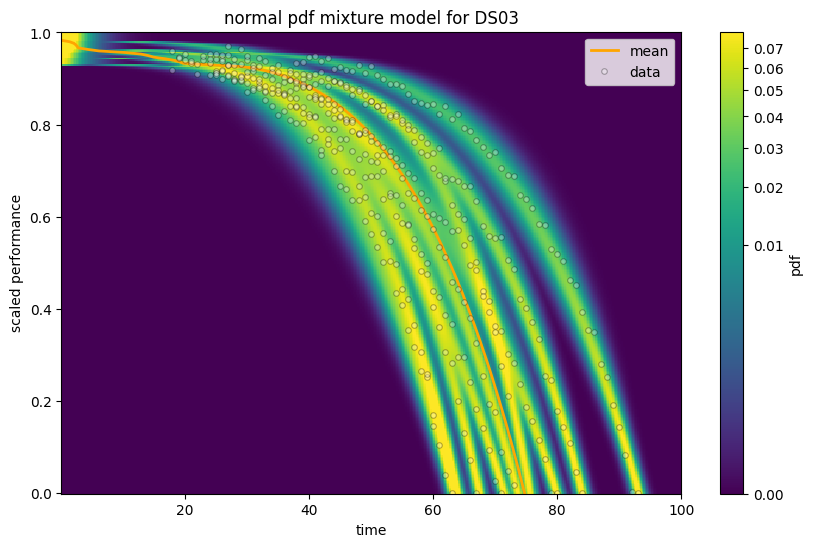

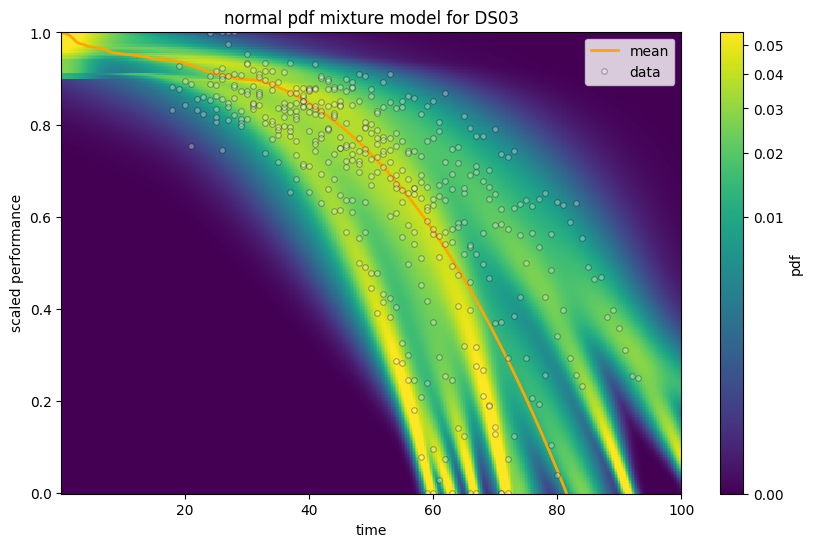

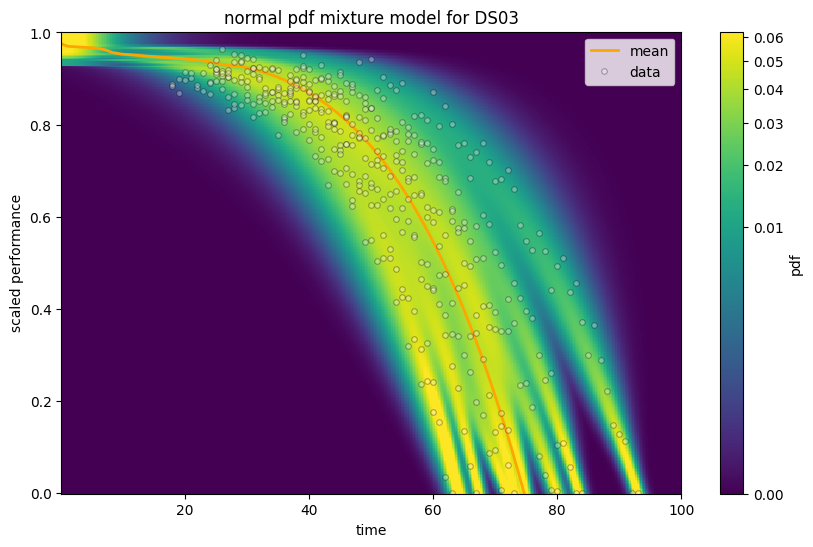

In [53]:
for name, models in norm_models.items():
    weights = torch.ones(len(models)) / len(models)
    s_data = s_datas[name]
    t_data = t_datas[name]
    mix = MixtureDEGModel(models, weights)
    ax=mix.plot_distribution(t, s, 
                    func="pdf",
					title=f"normal pdf mixture model for {data_name}",
		)
    ax.set_xlim([t.min(), t.max()])
    ax.plot(t_data,s_data,'o',
			color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
			label='data')
    ax.legend()
    plt.show()